## Import Modules

In [1]:
import os
import shutil
from datetime import datetime

from PIL import Image
import pandas
import numpy

import matplotlib.pyplot as plt
import seaborn


from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search

## Data Preparation Part 1 (creating the csv)

### numpy.dot example

In [2]:
numpy.dot((100,100,100), [0.5, 0.2, 0.1])

80.0

In [3]:
seaborn.set(rc = {"figure.figsize":(12,10)})

### Rename all images with flower type 

```python
directories = ["/users/danielcorcoran/desktop/flowers/daisy/",
              "/users/danielcorcoran/desktop/flowers/tulip/",
              "/users/danielcorcoran/desktop/flowers/sunflower/",
              "/users/danielcorcoran/desktop/flowers/dandelion/",
              "/users/danielcorcoran/desktop/flowers/rose/"]
```

```python 

for directory in directories:

    flower_type = directory.split("/")[-2]
    
    for filename in os.listdir(directory):
        
        print(flower_type, filename)
        os.rename(directory+filename, directory+flower_type +"_" + filename)
        
```

### Create Dataframe containing all flower image data

In [4]:
directory_path = "./all_flowers/"

In [5]:
dataset = pandas.DataFrame()

In [6]:
counter = 0

for filename in os.listdir(directory_path):
    
    filepath = directory_path + filename
    if ".jpg" in filename:
        image = Image.open(filepath)
        size = image.size
        width = int(image.size[0])
        height = int(image.size[1])
        size = str(width) + "x" + str(height)
        category = filename.split("_")[0]
        
        dataset.loc[counter, "file_name"] = filename
        dataset.loc[counter, "file_path"] = directory_path
        dataset.loc[counter, "width"] = width
        dataset.loc[counter, "height"] = height
        dataset.loc[counter, "size"] = size
        dataset.loc[counter, "flower_type"] = category
        
        counter = counter + 1

In [7]:
grouped = dataset.groupby("size").count()
grouped.sort_values(by = "file_name", ascending = False).head()

,file_name,file_path,width,height,flower_type
size,,,,,
320x240,604,604,604,604,604


### Create subset containing only 320x240 images

In [8]:
data320x240 = dataset[dataset["size"] == "320x240"]

### Reset index

In [9]:
data320x240.reset_index(drop = True, inplace = True)

In [10]:
data320x240.head(3)

,file_name,file_path,width,height,size,flower_type
0,daisy_144099102_bf63a41e4f_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy
1,tulip_4612075317_91eefff68c_n.jpg,./all_flowers/,320.0,240.0,320x240,tulip
2,daisy_2578695910_5ab8ee17c1_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy


In [11]:
data320x240["full_path"] = data320x240["file_path"] + data320x240["file_name"]

In [12]:
data320x240.head(3)

,file_name,file_path,width,height,size,flower_type,full_path
0,daisy_144099102_bf63a41e4f_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy,./all_flowers/daisy_144099102_bf63a41e4f_n.jpg
1,tulip_4612075317_91eefff68c_n.jpg,./all_flowers/,320.0,240.0,320x240,tulip,./all_flowers/tulip_4612075317_91eefff68c_n.jpg
2,daisy_2578695910_5ab8ee17c1_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy,./all_flowers/daisy_2578695910_5ab8ee17c1_n.jpg


## Data Preparation Part 2 (for model)

### Feature engineering
Collect RGB features 

### A function used to map greyscales to pixel tuples returned by Image.getdata

In [13]:
def get_greyscale(pixel_tuple):
    
    # multiplier for grey scale value obtained from link below:
    # https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
    
    grey_scale_value = numpy.dot(pixel_tuple, [0.299, 0.587, 0.114])
    
    return grey_scale_value

### A function to generate a PIL.Image object and generate list of greyscale values given a path to an image

In [14]:
def get_image_data(path):
    
    image = Image.open(path)
    pixels = list(image.getdata())
    
    grey_scale_value = list(map(get_greyscale, pixels))

    return grey_scale_value

In [15]:
start = datetime.now()

data320x240["image_data_mapped"] = data320x240["full_path"].map(get_image_data)

print("Finished in: {}".format(datetime.now() - start))

Finished in: 0:01:55.836020


In [16]:
data320x240.head()

,file_name,file_path,width,height,size,flower_type,full_path,image_data_mapped
0,daisy_144099102_bf63a41e4f_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy,./all_flowers/daisy_144099102_bf63a41e4f_n.jpg,"[67.82799999999999, 24.820999999999998, 20.918..."
1,tulip_4612075317_91eefff68c_n.jpg,./all_flowers/,320.0,240.0,320x240,tulip,./all_flowers/tulip_4612075317_91eefff68c_n.jpg,"[121.82300000000001, 132.782, 139.891, 147.927..."
2,daisy_2578695910_5ab8ee17c1_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy,./all_flowers/daisy_2578695910_5ab8ee17c1_n.jpg,"[135.16099999999997, 129.64499999999998, 127.1..."
3,rose_5721768347_2ec4d2247b_n.jpg,./all_flowers/,320.0,240.0,320x240,rose,./all_flowers/rose_5721768347_2ec4d2247b_n.jpg,"[168.986, 168.102, 166.84199999999998, 167.906..."
4,daisy_8709110478_60d12efcd4_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy,./all_flowers/daisy_8709110478_60d12efcd4_n.jpg,"[27.942, 29.11, 28.061, 22.115, 11.838, 6.191,..."


### Create new dataframe splitting image_data_mapped lists into multiple columns

In [17]:
expanded_data = data320x240["image_data_mapped"].apply(pandas.Series)

In [18]:
expanded_data.head()

,0,1,2,3,4,5,6,7,8,9,...,76790,76791,76792,76793,76794,76795,76796,76797,76798,76799
0,67.828,24.821,20.918,7.288,21.882,5.288,36.226,18.146,12.164,64.061,...,42.014,20.937,30.693,62.717,51.857,47.047,30.899,45.376,55.236,13.098
1,121.823,132.782,139.891,147.927,148.160,142.145,150.974,166.122,171.847,172.097,...,80.267,75.093,77.839,94.357,42.965,61.316,71.882,74.250,92.211,74.657
2,135.161,129.645,127.129,132.445,139.832,141.843,135.125,128.347,123.297,126.936,...,123.006,124.006,121.718,122.718,122.718,123.718,123.718,124.718,124.718,125.718
3,168.986,168.102,166.842,167.907,164.995,156.089,144.209,134.121,131.915,129.872,...,187.890,186.249,192.726,187.840,186.709,187.866,179.838,166.169,159.717,162.233
4,27.942,29.110,28.061,22.115,11.838,6.191,12.208,22.094,19.143,17.143,...,31.813,35.058,35.792,36.710,38.041,37.910,35.149,29.872,23.231,18.573


### Join split data onto original dataframe

In [19]:
full_data = pandas.concat([data320x240, expanded_data], axis = 1)

In [20]:
full_data.head()

,file_name,file_path,width,height,size,flower_type,full_path,image_data_mapped,0,1,...,76790,76791,76792,76793,76794,76795,76796,76797,76798,76799
0,daisy_144099102_bf63a41e4f_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy,./all_flowers/daisy_144099102_bf63a41e4f_n.jpg,"[67.82799999999999, 24.820999999999998, 20.918...",67.828,24.821,...,42.014,20.937,30.693,62.717,51.857,47.047,30.899,45.376,55.236,13.098
1,tulip_4612075317_91eefff68c_n.jpg,./all_flowers/,320.0,240.0,320x240,tulip,./all_flowers/tulip_4612075317_91eefff68c_n.jpg,"[121.82300000000001, 132.782, 139.891, 147.927...",121.823,132.782,...,80.267,75.093,77.839,94.357,42.965,61.316,71.882,74.250,92.211,74.657
2,daisy_2578695910_5ab8ee17c1_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy,./all_flowers/daisy_2578695910_5ab8ee17c1_n.jpg,"[135.16099999999997, 129.64499999999998, 127.1...",135.161,129.645,...,123.006,124.006,121.718,122.718,122.718,123.718,123.718,124.718,124.718,125.718
3,rose_5721768347_2ec4d2247b_n.jpg,./all_flowers/,320.0,240.0,320x240,rose,./all_flowers/rose_5721768347_2ec4d2247b_n.jpg,"[168.986, 168.102, 166.84199999999998, 167.906...",168.986,168.102,...,187.890,186.249,192.726,187.840,186.709,187.866,179.838,166.169,159.717,162.233
4,daisy_8709110478_60d12efcd4_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy,./all_flowers/daisy_8709110478_60d12efcd4_n.jpg,"[27.942, 29.11, 28.061, 22.115, 11.838, 6.191,...",27.942,29.110,...,31.813,35.058,35.792,36.710,38.041,37.910,35.149,29.872,23.231,18.573


### Export Data

In [22]:
full_data.to_csv("/users/danielcorcoran/desktop/flowers_320x240_data_final.csv", 
                 index_label= "row_index")

## Read in data 

In [23]:
data = pandas.read_csv("/users/danielcorcoran/desktop/flowers_320x240_data_final.csv")

In [24]:
data.head(5)

,row_index,file_name,file_path,width,height,size,flower_type,full_path,image_data_mapped,0,...,76790,76791,76792,76793,76794,76795,76796,76797,76798,76799
0,0,daisy_144099102_bf63a41e4f_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy,./all_flowers/daisy_144099102_bf63a41e4f_n.jpg,"[67.82799999999999, 24.820999999999998, 20.918...",67.828,...,42.014,20.937,30.693,62.717,51.857,47.047,30.899,45.376,55.236,13.098
1,1,tulip_4612075317_91eefff68c_n.jpg,./all_flowers/,320.0,240.0,320x240,tulip,./all_flowers/tulip_4612075317_91eefff68c_n.jpg,"[121.82300000000001, 132.782, 139.891, 147.927...",121.823,...,80.267,75.093,77.839,94.357,42.965,61.316,71.882,74.250,92.211,74.657
2,2,daisy_2578695910_5ab8ee17c1_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy,./all_flowers/daisy_2578695910_5ab8ee17c1_n.jpg,"[135.16099999999997, 129.64499999999998, 127.1...",135.161,...,123.006,124.006,121.718,122.718,122.718,123.718,123.718,124.718,124.718,125.718
3,3,rose_5721768347_2ec4d2247b_n.jpg,./all_flowers/,320.0,240.0,320x240,rose,./all_flowers/rose_5721768347_2ec4d2247b_n.jpg,"[168.986, 168.102, 166.84199999999998, 167.906...",168.986,...,187.890,186.249,192.726,187.840,186.709,187.866,179.838,166.169,159.717,162.233
4,4,daisy_8709110478_60d12efcd4_n.jpg,./all_flowers/,320.0,240.0,320x240,daisy,./all_flowers/daisy_8709110478_60d12efcd4_n.jpg,"[27.942, 29.11, 28.061, 22.115, 11.838, 6.191,...",27.942,...,31.813,35.058,35.792,36.710,38.041,37.910,35.149,29.872,23.231,18.573


In [25]:
X = data.drop(['row_index',
 'file_name',
 'file_path',
 'width',
 'height',
 'size',
 'flower_type',
 'full_path',
 'image_data_mapped'], axis = 1)

y = data["flower_type"]

In [26]:
X.shape

(604, 76800)

In [27]:
y.shape

(604,)

In [28]:
y.unique()

array(['daisy', 'tulip', 'rose', 'sunflower', 'dandelion'], dtype=object)

In [29]:
mapping = {
    "daisy":0,
    "tulip":1,
    "rose":2,
    "sunflower":3,
    "dandelion":4
}

In [30]:
y_numeric = y.replace(mapping)

## Modelling (Naive Bayes)

### Round 1, using Gaussian Naive Bayes, and grey scale colours

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split

In [32]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_numeric, test_size = .20, random_state = 42)

In [33]:
model = GaussianNB()

In [34]:
model.fit(Xtrain, ytrain)

GaussianNB(priors=None)

In [35]:
y_pred = model.predict(Xtest)

In [36]:
accuracy_score(y_pred, ytest)

0.4214876033057851

In [37]:
y_pred[:50]

array([3, 4, 4, 1, 3, 1, 3, 1, 1, 4, 4, 3, 3, 3, 3, 2, 4, 4, 1, 2, 0, 2,
       0, 3, 4, 1, 2, 4, 3, 4, 1, 4, 4, 3, 1, 4, 3, 4, 3, 4, 0, 2, 3, 3,
       3, 1, 4, 2, 0, 0])

### Round 2, using Gausian Naive Bayes, and  binaries derived from grey scale colours

In [38]:
Xb = X

In [39]:
Xb.head()

,0,1,2,3,4,5,6,7,8,9,...,76790,76791,76792,76793,76794,76795,76796,76797,76798,76799
0,67.828,24.821,20.918,7.288,21.882,5.288,36.226,18.146,12.164,64.061,...,42.014,20.937,30.693,62.717,51.857,47.047,30.899,45.376,55.236,13.098
1,121.823,132.782,139.891,147.927,148.160,142.145,150.974,166.122,171.847,172.097,...,80.267,75.093,77.839,94.357,42.965,61.316,71.882,74.250,92.211,74.657
2,135.161,129.645,127.129,132.445,139.832,141.843,135.125,128.347,123.297,126.936,...,123.006,124.006,121.718,122.718,122.718,123.718,123.718,124.718,124.718,125.718
3,168.986,168.102,166.842,167.907,164.995,156.089,144.209,134.121,131.915,129.872,...,187.890,186.249,192.726,187.840,186.709,187.866,179.838,166.169,159.717,162.233
4,27.942,29.110,28.061,22.115,11.838,6.191,12.208,22.094,19.143,17.143,...,31.813,35.058,35.792,36.710,38.041,37.910,35.149,29.872,23.231,18.573


### Helper function to convert to binary 

In [40]:
def convert_greyscale_to_binary(number):

    if number >= 127.5:
                new_number = 1
    else:
                new_number = 0
    
    return new_number

In [41]:
Xb_final = Xb.applymap(convert_greyscale_to_binary)

In [42]:
Xb_final.head()

,0,1,2,3,4,5,6,7,8,9,...,76790,76791,76792,76793,76794,76795,76796,76797,76798,76799
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xb_final, y_numeric, test_size = .30, random_state = 42)

In [44]:
model = GaussianNB()

In [45]:
model.fit(Xtrain, ytrain)

GaussianNB(priors=None)

In [46]:
y_pred = model.predict(Xtest)

In [47]:
accuracy_score(y_pred, ytest)

0.3791208791208791

## Modelling (Principal Component Analysis + Support Vector Machine)

### Import sklearn

In [48]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

### Instantiate the model

In [49]:
pca = PCA(svd_solver='randomized', 
          n_components = 4,
          whiten = True, 
          random_state = 42)

svc = SVC(kernel = "rbf", 
          class_weight = "balanced")

model = make_pipeline(pca, 
                      svc)

### Split target vector and feature matrix into train and test subsets

In [50]:
Xtrain, Xtest, ytrain, ytest  = train_test_split(X, #flowers feature matrix
                                                 y_numeric, #flowers target matrix
                                                 random_state = 42,
                                                 test_size = 0.5)

### Fit the model

In [51]:
param_grid = {"svc__C": [1, 5, 10, 50],
             "svc__gamma":[0.0001, 0.0005, 0.001, 0.005, 0.0075, 0.01]}

grid = GridSearchCV(model, param_grid)
%time grid.fit(Xtrain, ytrain)

print(grid.best_params_)

CPU times: user 2min 57s, sys: 18.7 s, total: 3min 15s
Wall time: 53.5 s
{'svc__C': 50, 'svc__gamma': 0.01}


### Predict using model built with test data

In [52]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

### Check Accuracy

In [53]:
accuracy_score(yfit, ytest)

0.3609271523178808

### Generate Classification report

In [54]:
report = classification_report(ytest, 
                            yfit, 
                            target_names = mapping.keys())

print(report)

             precision    recall  f1-score   support

      daisy       0.29      0.46      0.36        50
      tulip       0.32      0.44      0.37        61
       rose       0.44      0.16      0.24        50
  sunflower       0.46      0.44      0.45        77
  dandelion       0.36      0.27      0.31        64

avg / total       0.38      0.36      0.35       302



Text(84.4531,0.5,'Predicted label')

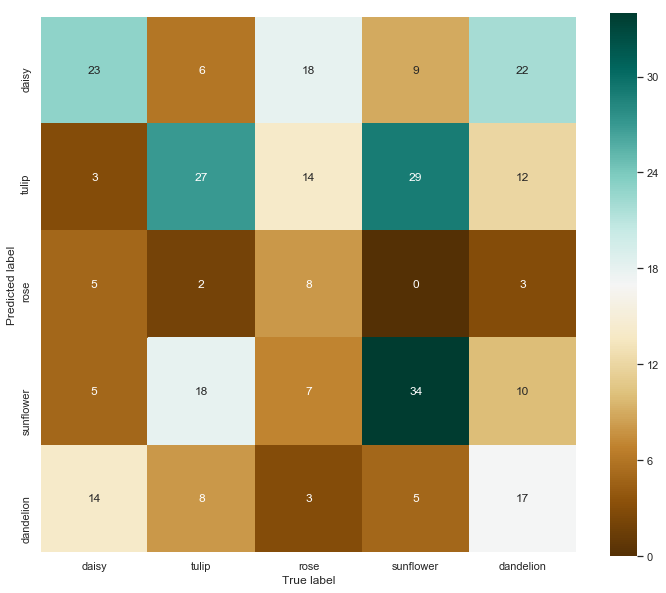

In [55]:
mat = confusion_matrix(ytest, yfit)

seaborn.heatmap(mat.T, 
                square = True, 
                annot = True, 
                fmt = "d", 
                cmap = "BrBG",
               xticklabels = mapping.keys(),
               yticklabels = mapping.keys())

plt.xlabel("True label")
plt.ylabel("Predicted label")